## Menguji Dataset WAV

**Penerapan Algoritma CNN Untuk Translasi Wicara Menjadi Teks**

**Nama: Thenardhi Syechlo**

**Prodi: Informatika**

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [1]:
import numpy as np
import librosa as lr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle as pk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras

# Menguji Dataset untuk Speech Recognition Training

In [2]:
dataset='400_wav'
pd.DataFrame(os.listdir(dataset),columns=['Files'])

,Files
0,anjing
1,api
2,babi
3,badak
4,bakso bulat
5,biru
6,buku
7,domba
8,gunung
9,hijau


In [3]:
def count(path):
    size=[]
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
tr=count(dataset)
tr

,Number Of Sample
anjing,145
api,121
babi,106
badak,109
bakso bulat,107
biru,132
buku,165
domba,156
gunung,133
hijau,164


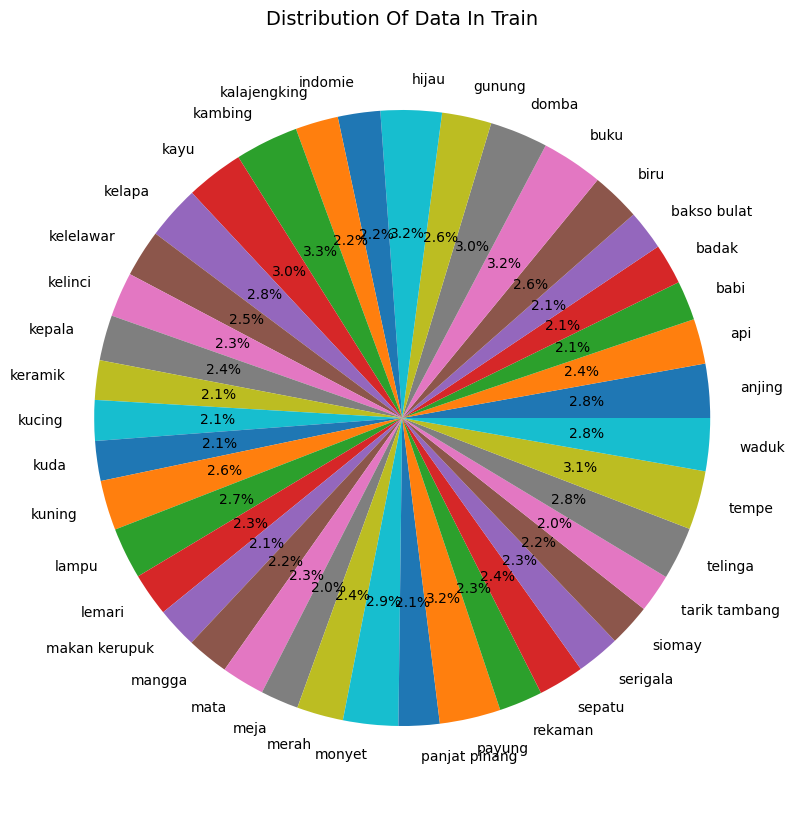

In [4]:
plt.figure(figsize=(10,10))
plt.pie(x='Number Of Sample',labels=os.listdir(dataset),autopct ='%1.1f%%',data=tr)
plt.title('Distribution Of Data In Train',fontsize=14)
plt.show()

Text(0, 0.5, 'Count')

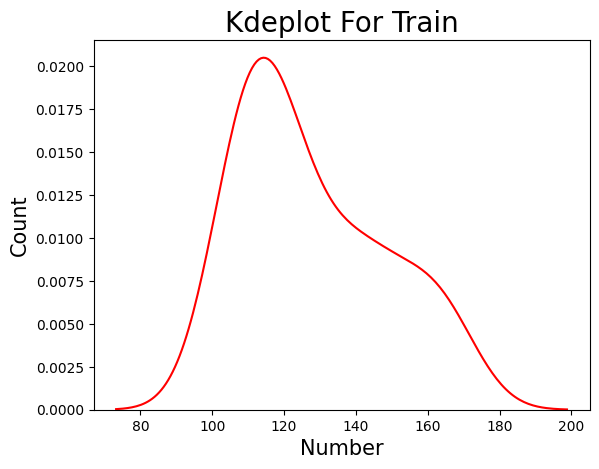

In [5]:
sns.kdeplot(tr['Number Of Sample'], color='red')
plt.title('Kdeplot For Train', fontsize=20)
plt.xlabel('Number', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [6]:
# Yellow Audio
ipd.Audio('400_wav/kuning/Kuning_71.wav')

In [7]:
# Mountain Audio
ipd.Audio('400_wav/gunung/Gunung_25.wav')

In [8]:
# Cat Audio
ipd.Audio('400_wav/kucing/Kucing_19.wav')

In [9]:
# Sheep Audio
ipd.Audio('400_wav/domba/Domba_16.wav')

In [10]:
# Cupboard Audio
ipd.Audio('400_wav/lemari/Lemari_04.wav')

In [11]:
def load(path):
    data=[]
    label=[]
    sample=[]
    for file in os.listdir(path):
        path_=os.path.join(path,file)
        for fil in os.listdir(path_):
            data_contain,sample_rate=lr.load(os.path.join(path_,fil))
            data.append(data_contain[:15360])
            sample.append(sample_rate)
            label.append(file)
    return data,label,sample

In [12]:
data,label,sample=load(dataset)
df=pd.DataFrame()
df['Label'],df['sample']=label,sample
df

,Label,sample
0,anjing,22050
1,anjing,22050
2,anjing,22050
3,anjing,22050
4,anjing,22050
...,...,...
5115,waduk,22050
5116,waduk,22050
5117,waduk,22050
5118,waduk,22050


## Audio Feature Extraction

In [13]:
#waveform
def waveform(data,sr,label):
    plt.figure(figsize=(14, 5))
    lr.display.waveshow(data, sr=sr)
    plt.suptitle(label)
    plt.title('Waveform plot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
#MFCC features
def mfcc(data, sr):
    mfccs = lr.feature.mfcc(y=data, sr=sr)
    return np.mean(mfccs), mfccs
def mfcc_v(mfccs,label):
    plt.figure(figsize=(10, 4))
    lr.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.suptitle(label)
#Mel-spectrogram
def Mel(data, sr):
    mel_spec = lr.feature.melspectrogram(y=data, sr=sr)
    return np.mean(mel_spec), mel_spec
def mel_v(mel_spec,label,sr):
    # Convert to decibel scale
    mel_spec_db = lr.power_to_db(mel_spec, ref=np.max)
    # Visualize Mel-spectrogram
    plt.figure(figsize=(10, 4))
    lr.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    plt.suptitle(label)
#zero_crossing_rate
def zero_crossing(data,sr):
    # Compute zero-crossing rate
    zcr = lr.feature.zero_crossing_rate(data)
    # Print average zero-crossing rate
    avg_zcr = sum(zcr[0])/len(zcr[0])
    print("Average zero-crossing rate:", avg_zcr)
    return zcr
def zero_crossing_v(zcr,label,data,sr):
    time = lr.times_like(zcr)
    # Create waveform plot
    plt.figure(figsize=(14, 5))
    lr.display.waveshow(data, sr=sr, alpha=0.5)
    plt.plot(time, zcr[0], color='r')
    plt.title('Zero-crossing rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.suptitle(label)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


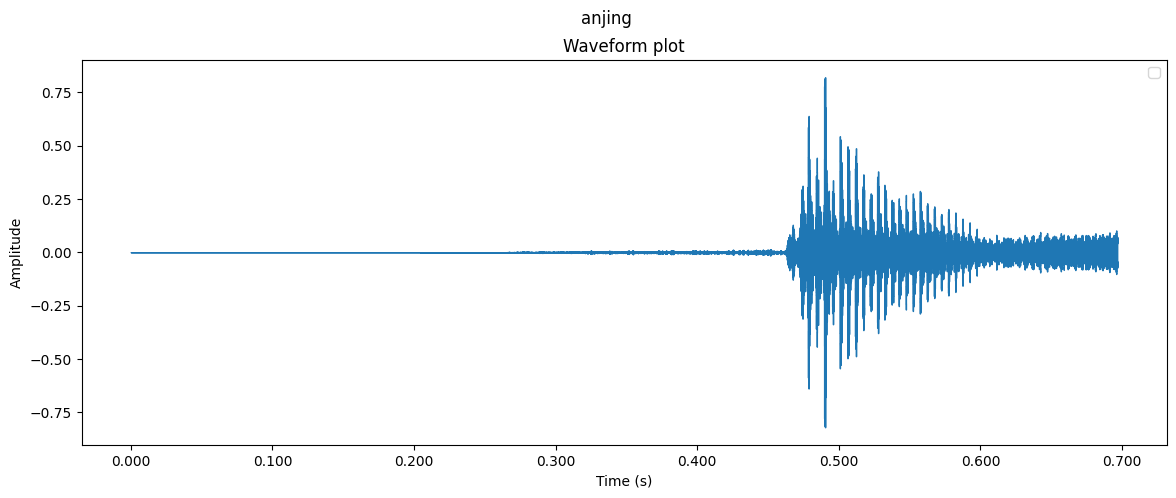

In [14]:
#waveform data[0]
waveform(data[0],sample[0],label[0])
plt.legend()

MFCCs Mean: -24.064386
MFCCs shape: (20, 31)


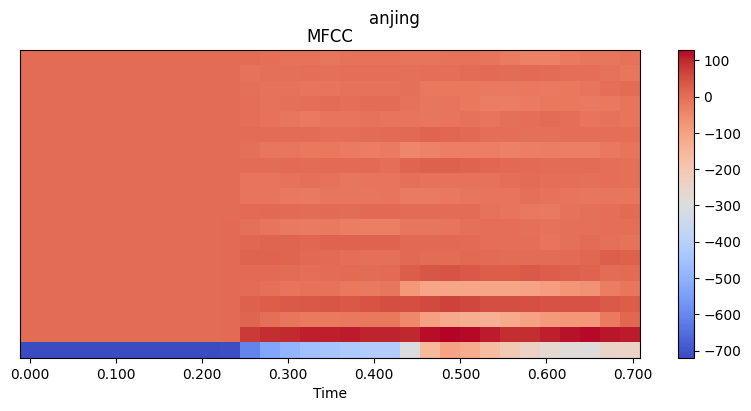

In [15]:
#MFCC data[0]
mfccs_mean, mfccs = mfcc(data[0], sample[0])
print('MFCCs Mean:', mfccs_mean)
print('MFCCs shape:', mfccs.shape)
mfcc_v(mfccs,label[0])

Mel Mean: 0.37440065
Mel : (128, 31)


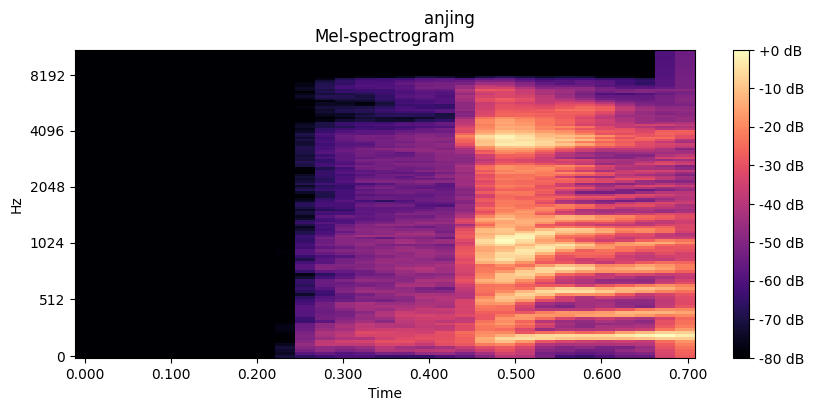

In [16]:
##Mel-spectrogram data[0]
mel_mean,mel=Mel(data[0],sample[0])
print('Mel Mean:',mel_mean)
print('Mel :',mel.shape)
mel_v(mel,label[0],sample[0])

Average zero-crossing rate: 0.09622290826612903
Zcr: (1, 31)


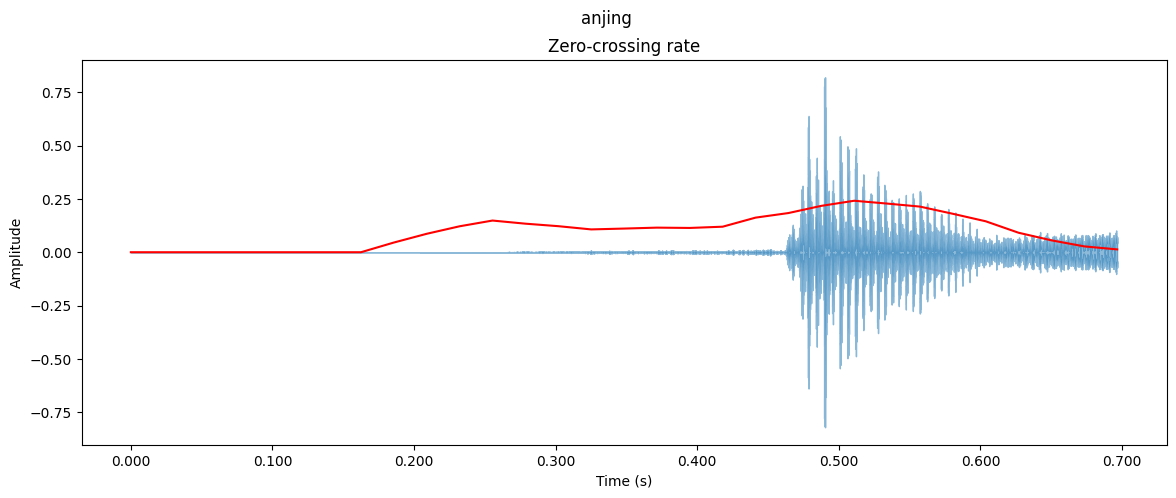

In [17]:
#zero_crossing data[0]
zcr=zero_crossing(data[0],sample[0])
print('Zcr:',zcr.shape)
zero_crossing_v(zcr,label[0],data[0],sample[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


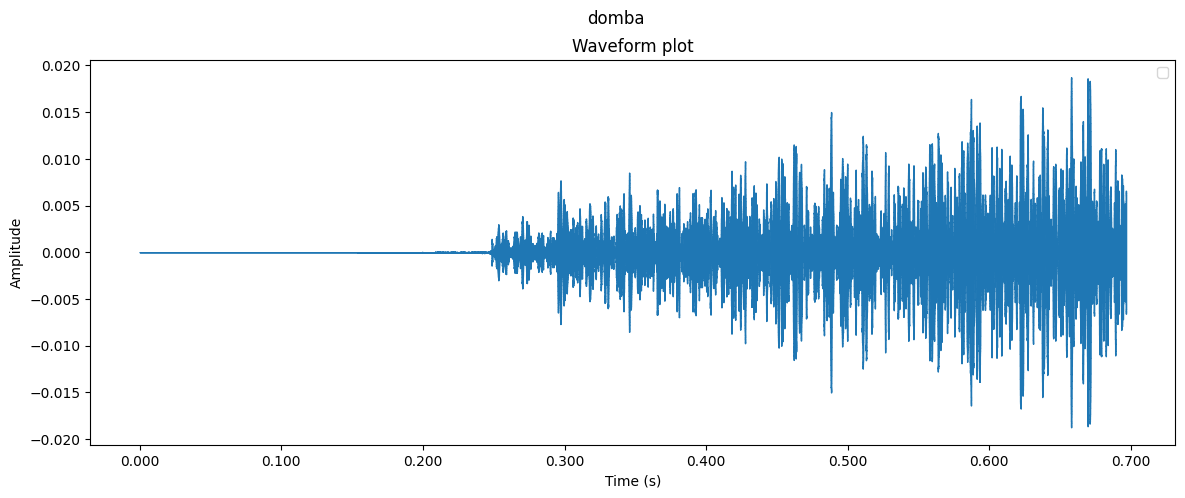

In [18]:
#waveform data[1000]
waveform(data[1000],sample[1000],label[1000])
plt.legend()

MFCCs Mean: -28.242647
MFCCs shape: (20, 31)


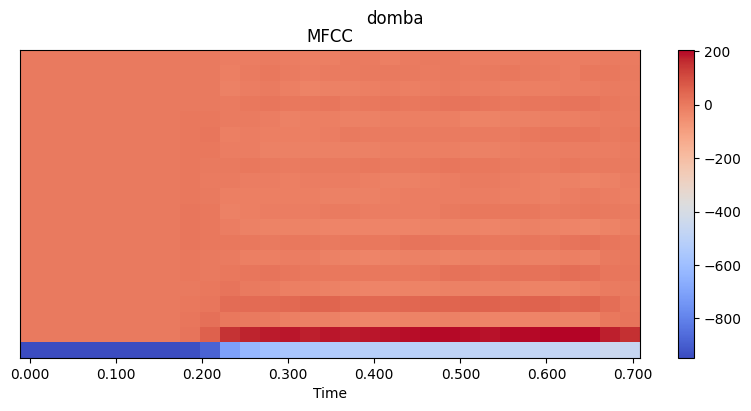

In [19]:
#MFCC data[1000]
mfccs_mean, mfccs = mfcc(data[1000], sample[1000])
print('MFCCs Mean:', mfccs_mean)
print('MFCCs shape:', mfccs.shape)
mfcc_v(mfccs,label[1000])

Mel Mean: 0.0032193365
Mel : (128, 31)


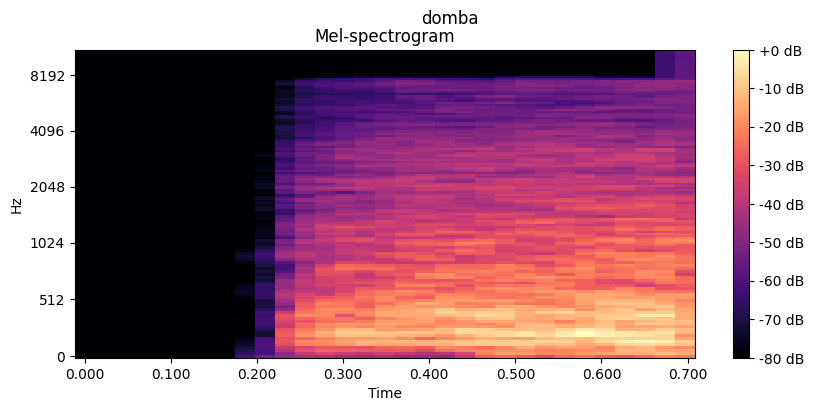

In [20]:
##Mel-spectrogram data[1000]
mel_mean,mel=Mel(data[1000],sample[1000])
print('Mel Mean:',mel_mean)
print('Mel :',mel.shape)
mel_v(mel,label[1000],sample[1000])

Average zero-crossing rate: 0.045315650201612906
Zcr: (1, 31)


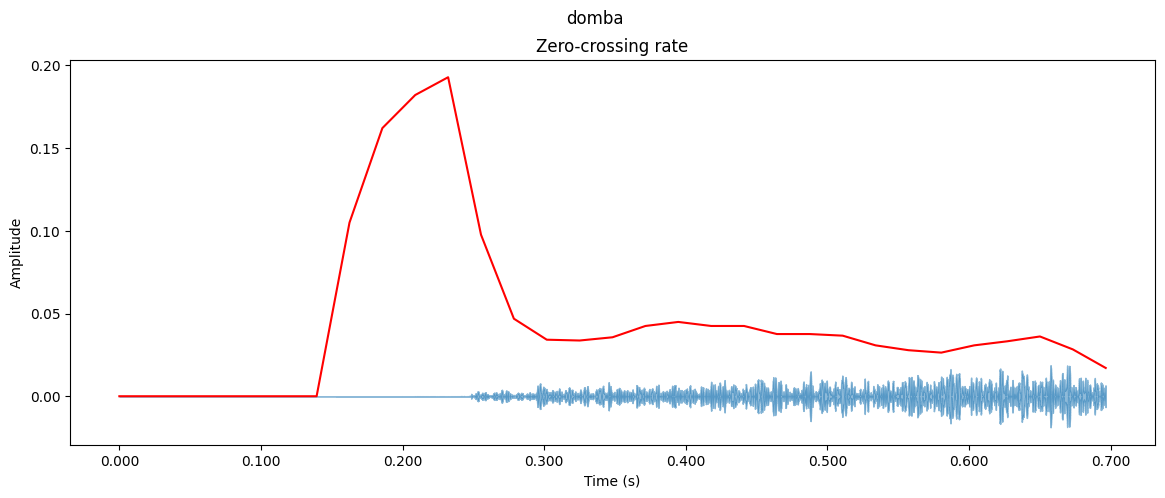

In [21]:
#zero_crossing data[1000]
zcr=zero_crossing(data[1000],sample[1000])
print('Zcr:',zcr.shape)
zero_crossing_v(zcr,label[1000],data[1000],sample[1000])

In [22]:
code={}
x=0
for i in pd.unique(label):
    code[i]=x
    x+=1
pd.DataFrame(code.values(),columns=['Value'],index=code.keys()) 

,Value
anjing,0
api,1
babi,2
badak,3
bakso bulat,4
biru,5
buku,6
domba,7
gunung,8
hijau,9


In [23]:
def get_Name(N):
    for x,y in code.items():
          if y==N:
                return x
for i in range(len(label)):
    label[i]=code[label[i]]
pd.DataFrame(label,columns=['Labels'])

,Labels
0,0
1,0
2,0
3,0
4,0
...,...
5115,39
5116,39
5117,39
5118,39


## Splitting Data

In [24]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(label)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(-1, 1)
one_hot_label = onehot_encoder.fit_transform(integer_encoded)

c:\Users\IP-03\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
data = np.array(data).reshape(-1, 15360, 1)
label = np.array(label)

# Replace 'y' with 'label' for stratification
X_train, X_test, y_train, y_test = train_test_split(data, one_hot_label, test_size=0.25, stratify=label, shuffle=True, random_state=44)
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape)
print('y_train shape is ', y_train.shape)
print('y_test shape is ', y_test.shape)

X_train = tf.convert_to_tensor(X_train.astype(np.float32))
X_test = tf.convert_to_tensor(X_test.astype(np.float32))
y_train = tf.convert_to_tensor(y_train.astype(np.float32))
y_test = tf.convert_to_tensor(y_test.astype(np.float32))


X_train shape is  (3840, 15360, 1)
X_test shape is  (1280, 15360, 1)
y_train shape is  (3840, 40)
y_test shape is  (1280, 40)


## Model Building

In [26]:
num_class=len(pd.unique(label))
model=keras.Sequential()
model.add(keras.layers.Conv1D(filters=8, kernel_size=13,activation=tf.nn.relu,input_shape=(15360,1)))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=16, kernel_size=11,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=32, kernel_size=9,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=64, kernel_size=7,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(num_class,activation=tf.nn.softmax))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15348, 8)          112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5116, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5116, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5106, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1702, 16)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1702, 16)          0

In [28]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
model.compile(optimizer ='adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist=model.fit(X_train,y_train,epochs=40)

Epoch 1/40
120/120 [==============================] - 16s 122ms/step - loss: 3.6489 - accuracy: 0.0365
Epoch 2/40
120/120 [==============================] - 15s 121ms/step - loss: 3.3657 - accuracy: 0.0740
Epoch 3/40
120/120 [==============================] - 15s 121ms/step - loss: 3.1147 - accuracy: 0.1063
Epoch 4/40
120/120 [==============================] - 15s 122ms/step - loss: 2.7866 - accuracy: 0.1685
Epoch 5/40
120/120 [==============================] - 15s 121ms/step - loss: 2.4631 - accuracy: 0.2271
Epoch 6/40
120/120 [==============================] - 15s 121ms/step - loss: 2.2189 - accuracy: 0.2966
Epoch 7/40
120/120 [==============================] - 15s 121ms/step - loss: 2.0341 - accuracy: 0.3396
Epoch 8/40
120/120 [==============================] - 14s 121ms/step - loss: 1.9121 - accuracy: 0.3818
Epoch 9/40
120/120 [==============================] - 15s 122ms/step - loss: 1.7890 - accuracy: 0.4156
Epoch 10/40
120/120 [==============================] - 15s 121ms/step - l

In [30]:
loss,acc=model.evaluate(X_test,y_test)
print('Loss is :',loss)
print('ACC is :',acc)

40/40 [==============================] - 1s 21ms/step - loss: 2.2072 - accuracy: 0.4742
Loss is : 2.2071595191955566
ACC is : 0.4742187559604645


In [31]:
hist_=hist.history
pd.DataFrame(hist_)

,loss,accuracy
0,3.648851,0.036458
1,3.365730,0.073958
2,3.114705,0.106250
3,2.786604,0.168490
4,2.463076,0.227083
5,2.218879,0.296615
6,2.034127,0.339583
7,1.912084,0.381771
8,1.788999,0.415625
9,1.704631,0.437500


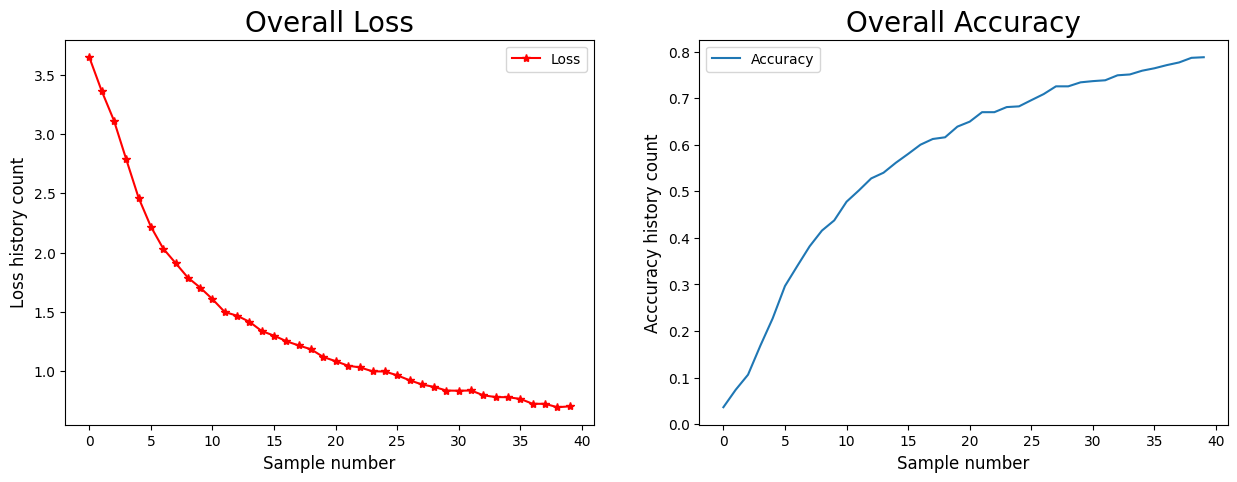

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],c='r',marker='*',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.xlabel('Sample number', fontsize=12)
plt.ylabel('Loss history count', fontsize=12)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.xlabel('Sample number', fontsize=12)
plt.ylabel('Acccuracy history count', fontsize=12)
plt.legend()

In [33]:
# Simpan akurasi ke dalam sebuah file teks
with open('akurasi1.txt', 'w') as file:
    file.write(str(acc))

In [34]:
predict=model.predict(X_test)
predict[0]

40/40 [==============================] - 1s 21ms/step


array([2.60089568e-08, 7.69392417e-13, 5.34058886e-09, 5.26589261e-08,
       2.17228467e-06, 4.70345096e-10, 9.49119783e-10, 1.79792745e-13,
       1.95053227e-11, 1.49726384e-10, 9.65798825e-16, 7.05560506e-20,
       4.05735995e-17, 6.08695950e-18, 6.32864490e-24, 1.43304370e-29,
       4.05969533e-18, 5.14070876e-20, 8.52341524e-21, 8.92922888e-13,
       1.06828466e-13, 6.67791289e-15, 5.39409300e-15, 1.13846715e-22,
       2.88389390e-03, 9.94546413e-01, 2.56363838e-03, 1.20112109e-09,
       4.65382186e-08, 3.77473316e-06, 3.02982223e-10, 3.94505229e-13,
       2.26108046e-24, 1.02368517e-22, 2.89982888e-18, 8.18654769e-13,
       2.11880329e-17, 2.57869497e-21, 2.72264742e-21, 4.76679751e-10],
      dtype=float32)

In [35]:
preN=[]
prename=[]
for row in predict:
    N=np.argmax(row)
    preN.append(N)
    prename.append(get_Name(N))
pd.DataFrame(prename,columns=['Predictions'])

,Predictions
0,mangga
1,kuda
2,mata
3,buku
4,sepatu
...,...
1275,api
1276,rekaman
1277,sepatu
1278,merah


In [36]:
def get_Name(N):
    # Assuming code.values() and N are both TensorFlow tensors
    N = np.argmax(N)
    matches = tf.equal(list(code.values()), N)
    indices = tf.where(matches)
    if tf.size(indices) > 0:
        return list(code.keys())[indices[0, 0].numpy()]

In [37]:
predict=[]
y_act=[]
for p in range(1280):
    y_act.append(get_Name(y_test[p]))
    predict.append(prename[p])
pd_p=pd.DataFrame(y_act,columns=['y_act'])  
pd_p['predict']=predict
pd_p

,y_act,predict
0,mangga,mangga
1,kuda,kuda
2,makan kerupuk,mata
3,buku,buku
4,kepala,sepatu
...,...,...
1275,api,api
1276,rekaman,rekaman
1277,sepatu,sepatu
1278,merah,merah


# Model Check

Confusion matrix is: 


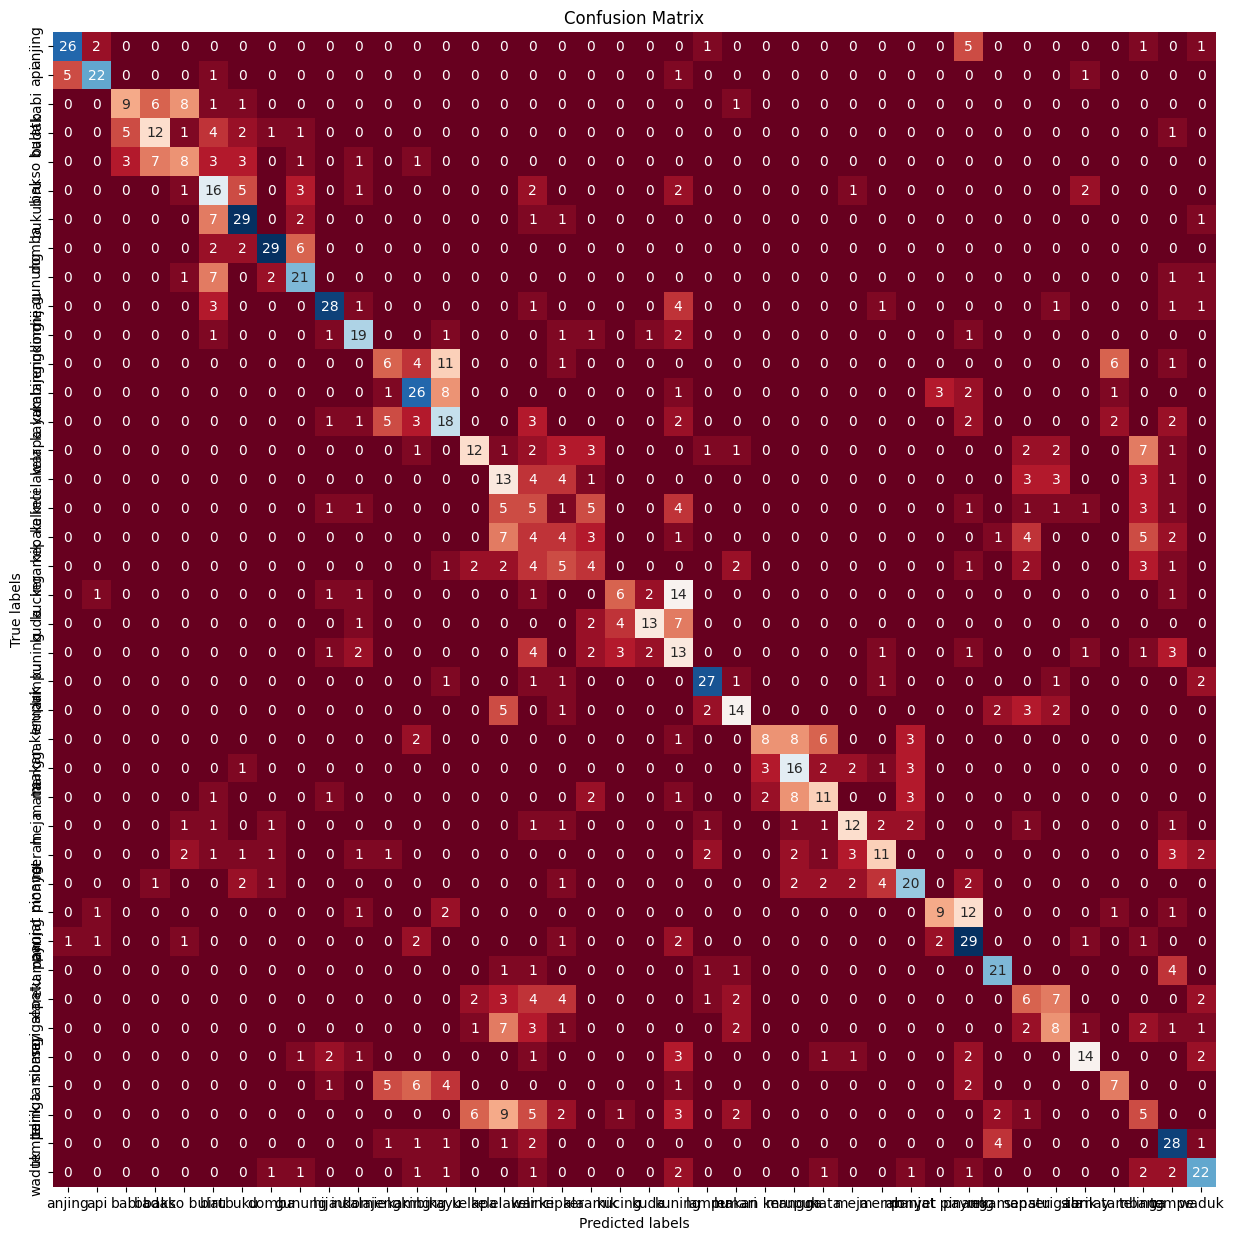

array([[26,  2,  0, ...,  1,  0,  1],
       [ 5, 22,  0, ...,  0,  0,  0],
       [ 0,  0,  9, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 28,  1],
       [ 0,  0,  0, ...,  2,  2, 22]], dtype=int64)

In [38]:
# Convert one-hot encoded true labels to integer labels
y_test_int = np.argmax(y_test, axis=1)

plt.figure(figsize=(15, 15))
ax = plt.subplot()
CM = confusion_matrix(y_test_int, preN)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(code.keys())
ax.yaxis.set_ticklabels(code.keys())
print('Confusion matrix is: ')
plt.show()
CM

In [39]:
# Classification report testing

# Print the classification report
print('Classification report is: ')
print(classification_report(y_act, predict))

Classification report is: 
               precision    recall  f1-score   support

       anjing       0.81      0.72      0.76        36
          api       0.81      0.73      0.77        30
         babi       0.53      0.35      0.42        26
        badak       0.46      0.44      0.45        27
  bakso bulat       0.35      0.30      0.32        27
         biru       0.33      0.48      0.40        33
         buku       0.63      0.71      0.67        41
        domba       0.81      0.74      0.77        39
       gunung       0.58      0.64      0.61        33
        hijau       0.76      0.68      0.72        41
      indomie       0.61      0.68      0.64        28
 kalajengking       0.32      0.21      0.25        29
      kambing       0.55      0.62      0.58        42
         kayu       0.38      0.46      0.41        39
       kelapa       0.52      0.33      0.41        36
    kelelawar       0.24      0.41      0.30        32
      kelinci       0.10      0.17   

## Save Model

In [40]:
model.save('test1.h5')

In [41]:
savedmodel=keras.models.load_model('test1.h5')

# Percobaan dan Pembukaan Model

In [42]:
import h5py

# Open the H5 file
with h5py.File('test1.h5', 'r') as file:
    # List all dataset names within the file
    dataset_names = list(file.keys())
    print("Available dataset names:", dataset_names)

Available dataset names: ['model_weights', 'optimizer_weights']


In [43]:
print("X_test", X_test)

X_test tf.Tensor(
[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.0659418 ]
  [ 0.06604245]
  [ 0.06656384]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.00149258]
  [-0.0015668 ]
  [-0.00829832]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.00657061]
  [-0.00444168]
  [-0.00015789]]

 ...

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.1460771 ]
  [ 0.13726857]
  [ 0.14826901]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.12275364]
  [-0.0894642 ]
  [-0.06339493]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.01886668]
  [ 0.03102936]
  [ 0.04452812]]], shape=(1280, 15360, 1), dtype=float32)


In [44]:
print("X_train", X_train)

X_train tf.Tensor(
[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.13110106]
  [-0.11048079]
  [-0.11315183]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.27693528]
  [ 0.32236665]
  [ 0.31936368]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.18650922]
  [ 0.16913821]
  [ 0.1151752 ]]

 ...

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.09478296]
  [ 0.09318852]
  [ 0.09353937]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.04417783]
  [-0.05407012]
  [-0.05720174]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.2724439 ]
  [-0.2624082 ]
  [-0.2936425 ]]], shape=(3840, 15360, 1), dtype=float32)


In [45]:
print("y_test", y_test)

y_test tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(1280, 40), dtype=float32)


In [46]:
print("y_train", y_train)

y_train tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(3840, 40), dtype=float32)


# Kesimpulan

Pengujian data suara ini dinyatakan sukses. Hal ini terlihat bahwa tingkat akurasi menembus rata-rata 75% dengan hasil jumlah data yang dilakukan testing sebanyak 1267 data dari 5065 data (25%). Waktu yang diperlukan dalam pengujian data ini adalah 2-3 bulan dikarenakan pengujian dilakukan dengan membuat data suara sendiri.